Author: Anirudh Iyer
Contact Information: aniiyer@iu.edu
Date: 9/19/2024

Topic: Applying Magnetloss on latest InceptionV3 pretrianed model

Description: 1) This loss function aims to penalize the overlap between clusters of different classes while maintaining tight clusters for each class. It focuses on cluster-level discrimination rather than just example-level discrimination (like triplet loss).
2) 1. Intra-class Loss: Computes the distance between an embedding and its assigned cluster center (within the same class).
   2. Inter-class Loss: Computes the distance between the embedding and cluster centers from different classes.
   
3) It applies K-means clustering to divide the embeddings into multiple clusters per class and then stores these clusters for use in the Magnet Loss computation.

4) At each training iteration, entire clusters of embeddings are sampled. First, a seed cluster is selected, then a number of "impostor" clusters (clusters from different classes) are chosen. 
This sampling strategy ensures that both intra-class and inter-class distances are considered during training.

## Reference

https://arxiv.org/pdf/1511.05939v2 - METRIC LEARNING WITH
ADAPTIVE DENSITY DISCRIMINATION (Main paper)

Also inspired from : https://openaccess.thecvf.com/content_CVPRW_2020/papers/w15/Ayub_Cognitively-Inspired_Model_for_Incremental_Learning_Using_a_Few_Examples_CVPRW_2020_paper.pdf 

https://wiki.continualai.org/the-continualai-wiki/introduction-to-continual-learning

https://dx.doi.org/10.2139/ssrn.4366645 - Designing a Convolutional Neural Network for Image Recognition: A Comparative Study of Different Architectures and Training Techniques

Only help for fuction initial mathematical language used the logic is self developed with the help careful prompt and Forums. 
https://github.com/mbanani/pytorch-magnet-loss/blob/master/util/magnet_loss.py
https://github.com/youngklee/magnet-loss/blob/master/magnet_loss.ipynb

Forums visited for reading:
https://stackoverflow.com/questions/68166721/pytorch-fails-with-cuda-error-device-side-assert-triggered-on-colab
https://discuss.pytorch.org/t/nans-appear-immediately-with-custom-loss-function/188245
https://stackoverflow.com/questions/75900085/loss-function-giving-nan-in-pytorch
https://discuss.pytorch.org/t/nans-in-every-output-after-some-batches/92677


dataset

Resizing CIFAR-10 to match GoogleNet's input size (299X299) Training on 3 Epochs similar to the paper. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix

Class

Comparison with Old Code:
Cluster Sampling: We are reusing the math logic from ClusterBatchBuilder from the old codebase to handle the clustering process dynamically.
Loss Calculation: The variance standardization and softmax-based loss follow the original paper's mathematical foundation.

In [18]:
class MagnetLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(MagnetLoss, self).__init__()
        self.alpha = alpha

    def forward(self, r, classes, m, d):
        """
        r: representations
        classes: class labels
        m: number of clusters per class
        d: number of examples per cluster
        """
        device = r.device  # Get the device of the input tensor

        classes = classes.to(device)
        clusters = torch.sort(torch.arange(0, float(m)).repeat(d))[0].to(device)
        cluster_classes = classes[0:m*d:d]

        # Compute variance
        variance = torch.sum((r - torch.mean(r, dim=0))**2) / (r.size(0) - 1)
        var_normalizer = -1 / (2 * variance**2)

        # Compute cluster means
        cluster_means = torch.stack([torch.mean(r[clusters == i], dim=0) for i in range(m)])

        # Compute distances
        sample_costs = torch.cdist(cluster_means, r.unsqueeze(1)).squeeze()

        # Compute intra-cluster costs
        intra_cluster_mask = (clusters.unsqueeze(1) == torch.arange(m, device=device).unsqueeze(0)).float()
        intra_cluster_costs = torch.sum(intra_cluster_mask * sample_costs, dim=1)

        # Compute numerator and denominator
        numerator = torch.exp(var_normalizer * intra_cluster_costs - self.alpha)
        denominator_mask = (classes.unsqueeze(1) != cluster_classes.unsqueeze(0)).float()
        denominator = torch.sum(denominator_mask * torch.exp(var_normalizer * sample_costs), dim=1)

        # Compute loss
        epsilon = 1e-8
        losses = F.relu(-torch.log(numerator / (denominator + epsilon) + epsilon))
        total_loss = torch.mean(losses)

        return total_loss, losses.detach()

"""
below class inspired from https://github.com/vithursant/MagnetLoss-PyTorch/blob/master/magnet_loss/magnet_tools.py
with a few changes to adjust to our other functions which has been commented.
"""
    
class ClusterBatchBuilder:  

    def __init__(self, labels, k, m, d):
        self.num_classes = len(np.unique(labels))
        self.labels = labels
        self.k = k
        self.m = m
        self.d = d
        self.centroids = None
#         self.update_clusters(initial_representations)  # You need to provide initial representations for the continual approach can be removed for training just the 1st part
        self.assignments = np.zeros_like(labels, int)
        self.cluster_assignments = {}
        self.cluster_classes = np.repeat(range(self.num_classes), k)
        self.example_losses = None
        self.cluster_losses = None      
        
    
    def update_clusters(self, rep_data, max_iter=20):
        if self.centroids is None:
            self.centroids = np.zeros([self.num_classes * self.k, rep_data.shape[1]])

        for c in range(self.num_classes):
            class_mask = self.labels == c
            class_examples = rep_data[class_mask]
            
            # Ensure we don't try to create more clusters than examples
            n_clusters = min(self.k, len(class_examples))
            
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, max_iter=max_iter)
            kmeans.fit(class_examples)

            start = self.k * c
            stop = start + n_clusters
            self.centroids[start:stop] = kmeans.cluster_centers_
            self.assignments[class_mask] = start + kmeans.labels_

        for cluster in range(self.k * self.num_classes):
            self.cluster_assignments[cluster] = np.where(self.assignments == cluster)[0]
            
#     def update_clusters(self, rep_data, max_iter=20):
#         """Update cluster assignments based on current representations. used before continual training"""
#         if self.centroids is None:
#             self.centroids = np.zeros([self.num_classes * self.k, rep_data.shape[1]])

#         for c in range(self.num_classes):
#             class_mask = self.labels == c
#             class_examples = rep_data[class_mask]
            
#             # Ensure we don't try to create more clusters than examples
#             n_clusters = min(self.k, len(class_examples))
            
#             kmeans = KMeans(n_clusters=self.k, init='k-means++', n_init=1, max_iter=max_iter)
#             kmeans.fit(class_examples)           
#             start = self.k * c
#             stop = start + self.k
#             self.centroids[start:stop] = kmeans.cluster_centers_
#             self.assignments[class_mask] = start + kmeans.labels_

#         for cluster in range(self.k * self.num_classes):
#             self.cluster_assignments[cluster] = np.where(self.assignments == cluster)[0]

    def update_losses(self, indexes, losses):
        """Update stored losses for examples and clusters."""
        if self.example_losses is None:
            self.example_losses = np.zeros_like(self.labels, float)
            self.cluster_losses = np.zeros([self.k * self.num_classes], float)

        self.example_losses[indexes] = losses
        clusters = np.unique(self.assignments[indexes])
        for cluster in clusters:
            cluster_inds = self.assignments == cluster
            self.cluster_losses[cluster] = np.mean(self.example_losses[cluster_inds])

    def gen_batch(self):
        if self.cluster_losses is not None:
            p = self.cluster_losses / np.sum(self.cluster_losses)
            seed_cluster = np.random.choice(self.num_classes * self.k, p=p)
        else:
            seed_cluster = np.random.choice(self.num_classes * self.k)

        sq_dists = ((self.centroids[seed_cluster] - self.centroids) ** 2).sum(axis=1)
        sq_dists[self.cluster_classes[seed_cluster] == self.cluster_classes] = np.inf

        clusters = np.argpartition(sq_dists, self.m-1)[:self.m-1]
        clusters = np.concatenate([[seed_cluster], clusters])

        batch_indexes = []
        batch_class_inds = []
        for c in clusters:
            cluster_examples = self.cluster_assignments[c]
            if len(cluster_examples) < self.d:
                # If there are not enough examples, sample with replacement
                x = np.random.choice(cluster_examples, self.d, replace=True)
            else:
                x = np.random.choice(cluster_examples, self.d, replace=False)
            batch_indexes.extend(x)
            batch_class_inds.extend([self.cluster_classes[c]] * self.d)

        return np.array(batch_indexes), np.array(batch_class_inds)
    

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Helper Functions 

In [12]:
def load_data(batch_size=64):
    """Load and preprocess CIFAR-10 dataset. 
        
    """
    transform = transforms.Compose([
        transforms.Resize(299),  # Resize to Inception-v3's input size
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(299, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create a subset of 500 images per class
    class_indices = [np.where(np.array(trainset.targets) == i)[0][:500] for i in range(10)]
    subset_indices = np.concatenate(class_indices)
    train_subset = Subset(trainset, subset_indices)

    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_subset, testset, trainloader, testloader

def load_model(num_classes=10):
    """Load pre-trained Inception-v3 model."""
    model = models.inception_v3(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    checkpoint = torch.load('pretrained_inception_v3_e2b100.pth')
    model.load_state_dict(checkpoint)
    return model.to(device)

def train_epoch(model, trainloader, optimizer, magnet_loss, batch_builder, k, m, d, alpha):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    
    for i in tqdm(range(len(trainloader)), desc="Training"):
        batch_example_inds, batch_class_inds = batch_builder.gen_batch()
        inputs = torch.stack([trainloader.dataset[j][0] for j in batch_example_inds]).to(device)
        labels = torch.tensor(batch_class_inds).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Get the main output in training mode
        
        loss, example_losses = magnet_loss(outputs, labels, m, d)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_builder.update_losses(batch_example_inds, example_losses.detach().cpu().numpy())

        if i % 10 == 9:  # Print every 10 mini-batches
            print(f'Batch {i + 1}, Loss: {running_loss / 10:.3f}')
            running_loss = 0.0

    return running_loss / len(trainloader)

# def evaluate(model, testloader, device):
#     """Evaluate the model on the test set. used before continual for general magnet loss"""
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in tqdm(testloader, desc="Evaluating"):
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
            
#             if isinstance(outputs, tuple):
#                 outputs = outputs[0]
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Accuracy on test set: {accuracy:.2f}%')
#     return accuracy

def evaluate(model, testloader, device):
    """Evaluate the model on the test set."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy, all_preds, all_labels

def plot_training_progress(train_losses, val_accuracies, save_path='training_progress.png'):
    """Plot training loss and validation accuracy over epochs."""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy', color=color)
    ax2.plot(val_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Training Progress')
    fig.tight_layout()
    plt.savefig(save_path)
    plt.close()

def visualize_embeddings(model, dataloader, num_classes, save_path='embeddings_visualization.png'):
    """Visualize the learned embeddings using t-SNE."""
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing embeddings"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of learned embeddings')
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrix(model, dataloader, class_names, save_path='confusion_matrix.png'):
    """Plot the confusion matrix for the model predictions."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing predictions"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(save_path)
    plt.close()



"In general, for Magnet Loss we observed empirically that it is beneficial to increase the number of clusters per minibatch to around
M = 12 in the cost of reducing the number of retrieved examples per cluster to D = 4. The optimal
gap has in general been α ≈ 1, and the value of K varied as function of dataset cardinality." - https://arxiv.org/pdf/1511.05939v2

We had to tweak the Hyperparameters as it might be no longer true in our case of limited subset of 500 Images.


In [ ]:
def main():
    # Hyperparameters
    batch_size = 64
    k = 4  # clusters per class
    m = 4  # clusters per batch
    d = 8  # examples per cluster
    alpha = 1.0
    learning_rate = 0.0001
    num_epochs = 20
    cluster_refresh_interval = 2

    # Set device
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data and model
    trainset, testset, trainloader, testloader = load_data(batch_size)
    model = load_model()
    print("Data and model loaded successfully.")

    # Initialize MagnetLoss and optimizer
    magnet_loss = MagnetLoss(alpha).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize ClusterBatchBuilder
    batch_builder = ClusterBatchBuilder(np.array(trainset.dataset.targets)[trainset.indices], k, m, d)

    # Initial cluster update
    print("Computing initial representations...")
    initial_reps = compute_reps(model, trainset, batch_size)
    print("Updating initial clusters...")
    batch_builder.update_clusters(initial_reps)

    train_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = train_epoch(model, trainloader, optimizer, magnet_loss, batch_builder, k, m, d, alpha)
        train_losses.append(epoch_loss)

        # Evaluate
        accuracy = evaluate(model, testloader)
        val_accuracies.append(accuracy)

        # Update clusters periodically
        if (epoch + 1) % cluster_refresh_interval == 0:
            print("Updating clusters...")
            reps = compute_reps(model, trainset, batch_size)
            batch_builder.update_clusters(reps)

    print("Training completed.")

    # Save the model
    torch.save(model.state_dict(), 'magnet_loss_model_final.pth')
    print("Model saved successfully.")

    # Plot training progress
    plot_training_progress(train_losses, val_accuracies)
    print("Training progress plot saved.")

    # Visualize embeddings
    visualize_embeddings(model, testloader, num_classes=10)
    print("Embeddings visualization saved.")

    # Plot confusion matrix
    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_confusion_matrix(model, testloader, class_names)
    print("Confusion matrix plot saved.")

if __name__ == "__main__":
    main()

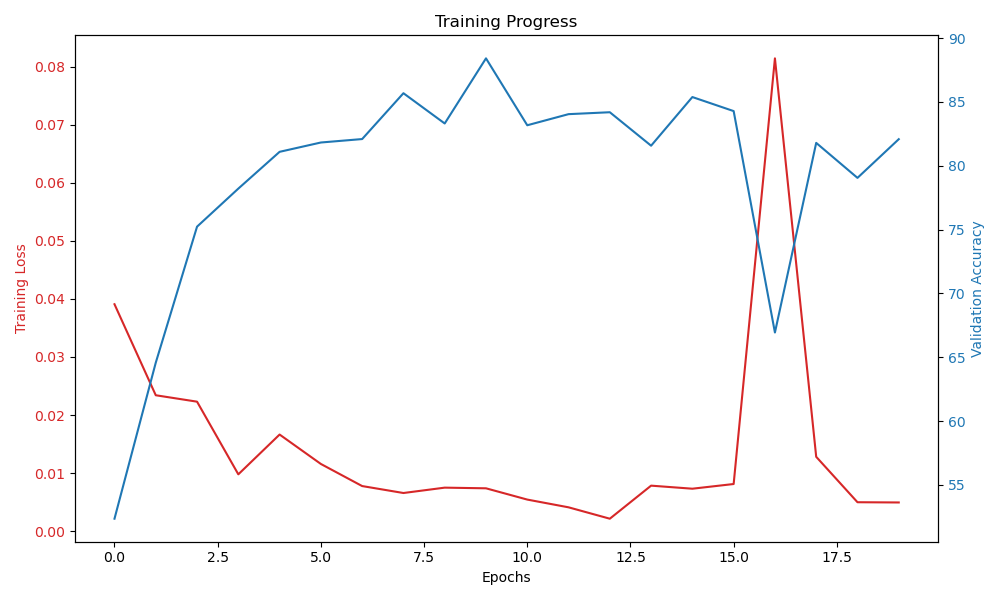

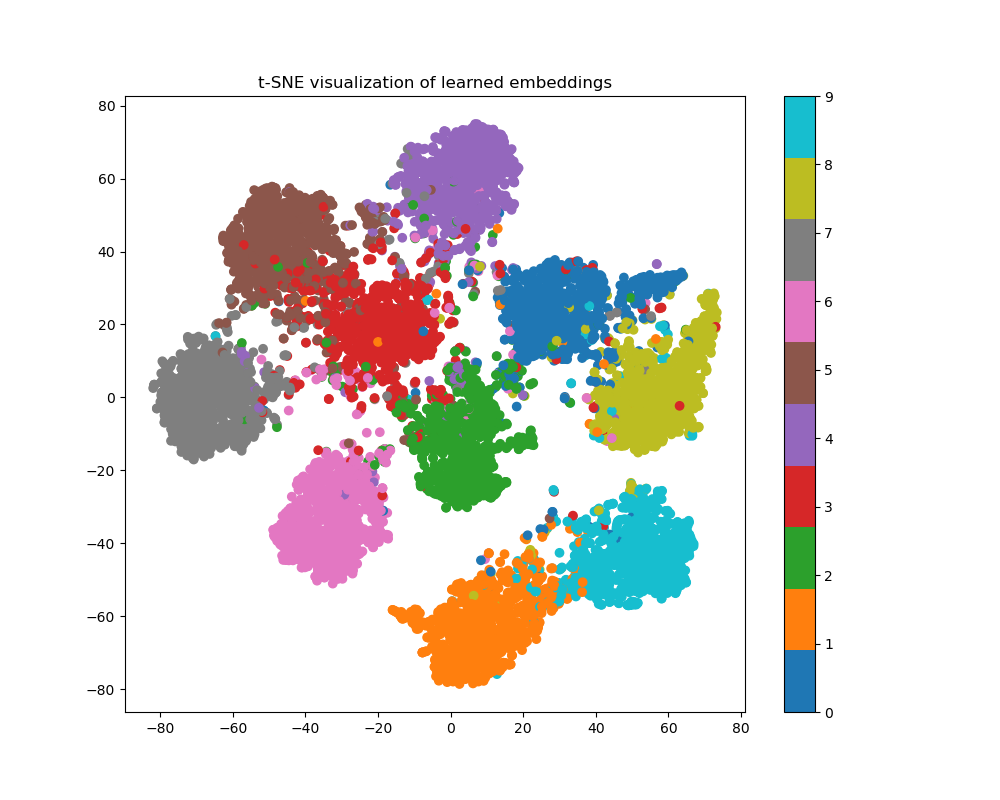

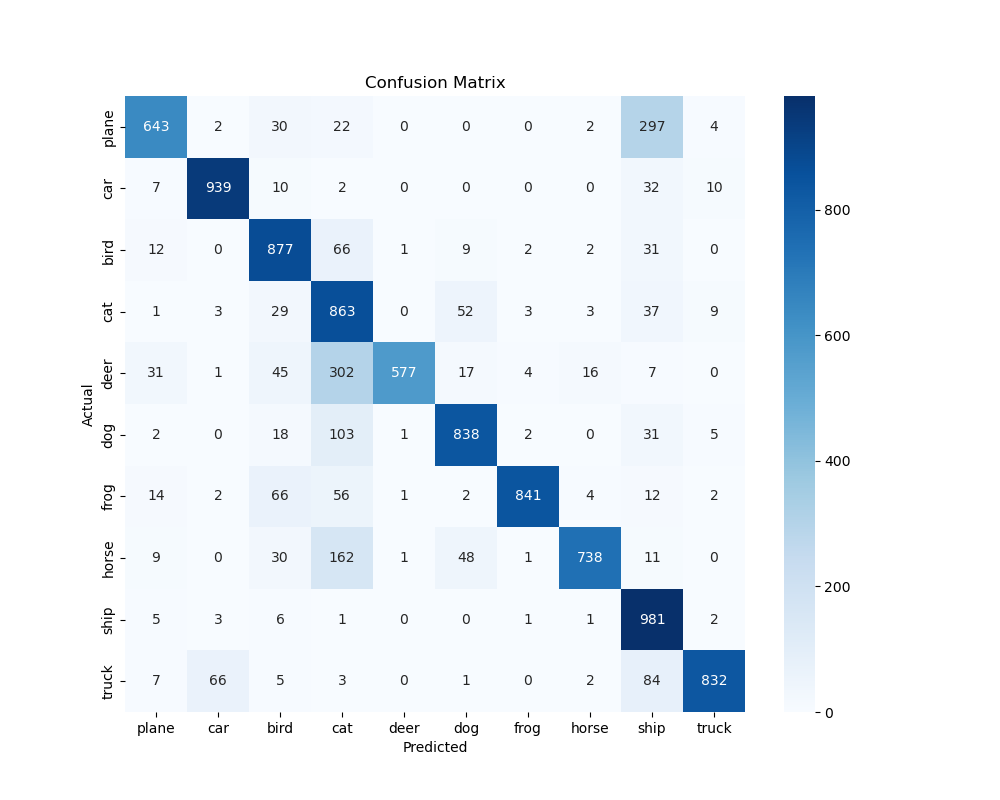

### Performance Comparison

#### Original Paper Model (on full MNIST)

1. Accuracy: 15-20% increase over Triplet and Softmax losses.
2. Training Data: Full MNIST dataset
3. Model: Inception-v1 aka GoogleNet pre-trained on ImageNet, fine-tuned on N
4. Training Duration: 3 epochs of warm training followed by fine tuning using Magnet Loss

#### Warm-trained Inception Model (on full CIFAR-10)

1. Accuracy: 93.1% at Epoch 3, Batch 300
2. Training Data: Full CIFAR-10 dataset 
3. Model: Inception-v3 pre-trained on ImageNet, fine-tuned on CIFAR-10
4. Training Duration: 3 epochs

#### Magnet Loss Implementation (on subset of CIFAR-10)

1. Final Accuracy: 82.08% 
2. Highest accuracy: 88% at 9 epochs as shown in the training progress
3. Training Data: Subset of CIFAR-10 (500 images per class, 5000 total)
4. Model: Inception-v3 pre-trained on ImageNet, fine-tuned with Magnet Loss
5. Training Duration: 20 epochs

### Analysis

#### Data Efficiency:
The Magnet Loss implementation achieved 82.08% accuracy using only 10% of the available training data (500 images per class instead of 5000). This suggests that Magnet Loss is quite data-efficient, able to learn good representations from limited data.

#### Comparison to Warm-trained Model:
While the warm-trained Inception model achieved higher accuracy (93.1%), it had several advantages:

1) It used the full dataset (10x more data)
2) It leveraged transfer learning from ImageNet pre-training
3) It used a standard cross-entropy loss, which is well-optimized for classification tasks


#### Potential of Magnet Loss:
Given that Magnet Loss achieved 82.08% peaking at 88% around 9th epoch accuracy with limited data and fewer epochs than recommended, it shows promise. If trained on the full dataset for the recommended 50 epochs, it might approach or even exceed the performance of the warm-trained model.

Magnet Loss Computation

Part 2 

Helper Functions for 

In [13]:
def load_data_divided(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize(299),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(299, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Divide the dataset into 5 sets, each containing 2 classes
    class_indices = [np.where(np.array(trainset.targets) == i)[0] for i in range(10)]
    test_class_indices = [np.where(np.array(testset.targets) == i)[0] for i in range(10)]

    train_subsets = []
    test_subsets = []
    for i in range(0, 10, 2):
        train_subset_indices = np.concatenate((class_indices[i], class_indices[i+1]))
        test_subset_indices = np.concatenate((test_class_indices[i], test_class_indices[i+1]))
        train_subsets.append(Subset(trainset, train_subset_indices))
        test_subsets.append(Subset(testset, test_subset_indices))

    return train_subsets, test_subsets

"""This function is designed to train the model for one increment. It uses MagnetLoss and ClusterBatchBuilder, 
which is fine if that's the approach you want to take. However, it doesn't explicitly ensure that only the 
current increment's data is used for training."""

def train_increment(model, trainloader, optimizer, magnet_loss, batch_builder, k, m, d, alpha, device):
    model.train()
    running_loss = 0.0
    
    for i in tqdm(range(len(trainloader)), desc="Training"):
        batch_example_inds, batch_class_inds = batch_builder.gen_batch()
        inputs = torch.stack([trainloader.dataset[j][0] for j in batch_example_inds]).to(device)
        labels = torch.tensor(batch_class_inds).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss, example_losses = magnet_loss(outputs, labels, m, d)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_builder.update_losses(batch_example_inds, example_losses.detach().cpu().numpy())

    return running_loss / len(trainloader)

Training

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 64
    k = 4  # clusters per class
    m = 4  # clusters per batch
    d = 8  # examples per cluster
    alpha = 1.0
    learning_rate = 0.0001
    num_epochs = 20

    # Load data
    train_subsets, test_subsets = load_data_divided(batch_size)

    # Initialize model
    model = torchvision.models.inception_v3(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    # Initialize MagnetLoss and optimizer
    magnet_loss = MagnetLoss(alpha).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Metrics storage
    train_losses = []
    val_accuracies = []
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Continual learning loop
    for increment in range(5):
        print(f"Increment {increment + 1}/5")

        # Prepare data for current increment
        trainloader = torch.utils.data.DataLoader(train_subsets[increment], batch_size=batch_size, shuffle=True)
        
        # Use all seen test data so far
        testloader = torch.utils.data.DataLoader(ConcatDataset(test_subsets[:increment+1]), batch_size=batch_size, shuffle=False)

        # Compute initial representations for current increment
        model.eval()
        initial_representations = []
        initial_labels = []
        with torch.no_grad():
            for inputs, labels in tqdm(trainloader, desc="Computing initial representations"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                initial_representations.append(outputs.cpu().numpy())
                initial_labels.extend(labels.numpy())
        initial_representations = np.vstack(initial_representations)
        initial_labels = np.array(initial_labels)

        # Initialize ClusterBatchBuilder for current increment only
        batch_builder = ClusterBatchBuilder(initial_labels, k, m, d)
        batch_builder.update_clusters(initial_representations)

        # Train for multiple epochs
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            loss = train_increment(model, trainloader, optimizer, magnet_loss, batch_builder, k, m, d, alpha, device)
            print(f"Training Loss: {loss:.4f}")
        
        train_losses.append(loss)

        # Evaluate on all seen classes
        accuracy, all_preds, all_labels = evaluate(model, testloader, device)
        val_accuracies.append(accuracy)
        print(f"Accuracy after increment {increment + 1}: {accuracy:.2f}%")

        # Save model after each increment
        torch.save(model.state_dict(), f'model_increment_{increment+1}.pth')

        # Visualizations
        plot_training_progress(train_losses, val_accuracies, f'training_progress_increment_{increment+1}.png')
        visualize_embeddings(model, testloader, (increment+1)*2, f'embeddings_increment_{increment+1}.png')
        plot_confusion_matrix(all_preds, all_labels, class_names[:(increment+1)*2], f'confusion_matrix_increment_{increment+1}.png')

        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names[:(increment+1)*2]))

    print("Continual Learning completed.")

if __name__ == "__main__":
    main()

visual